<a href="https://colab.research.google.com/github/abdulrahman-riyad/real-time-reviews-analysis/blob/Approach2/DataPrep_MLFineTuning2/data_preprocessing_reviews_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import numpy as np
import string
from google.colab import drive

In [2]:
drive.mount('/content/drive')
project_path = '/content/drive/My Drive/'

Mounted at /content/drive


# Data Exploration

In [3]:
df = pd.read_csv(project_path+'Womens Clothing E-Commerce Reviews.csv')
#/content/drive/MyDrive/Womens Clothing E-Commerce Reviews.csv

In [4]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [6]:
df.isnull().sum()

,0
Unnamed: 0,0
Clothing ID,0
Age,0
Title,3810
Review Text,845
Rating,0
Recommended IND,0
Positive Feedback Count,0
Division Name,14
Department Name,14


In [7]:
df['Review Text'][20]

"If this product was in petite, i would get the petite. the regular is a little long on me but a tailor can do a simple fix on that. \r\n\r\nfits nicely! i'm 5'4, 130lb and pregnant so i bough t medium to grow into. \r\n\r\nthe tie can be front or back so provides for some nice flexibility on form fitting."

In [8]:
df.drop(columns = ['Unnamed: 0', 'Clothing ID'], inplace = True)

<Axes: xlabel='Rating'>

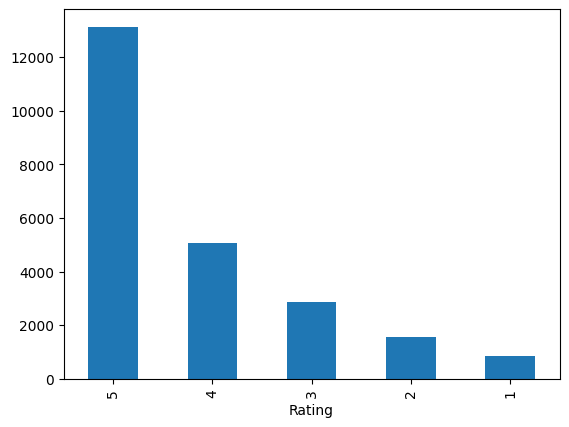

In [10]:
# Rating distribution
import matplotlib.pyplot as plt
import seaborn as sns
df['Rating'].value_counts().plot(kind='bar')

<Axes: xlabel='Recommended IND'>

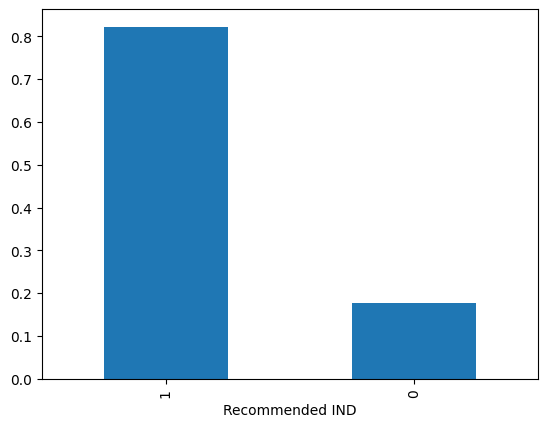

In [12]:
# Reccomendation distribution in percentage
df['Recommended IND'].value_counts(normalize=True).plot(kind='bar')

<Axes: xlabel='Department Name'>

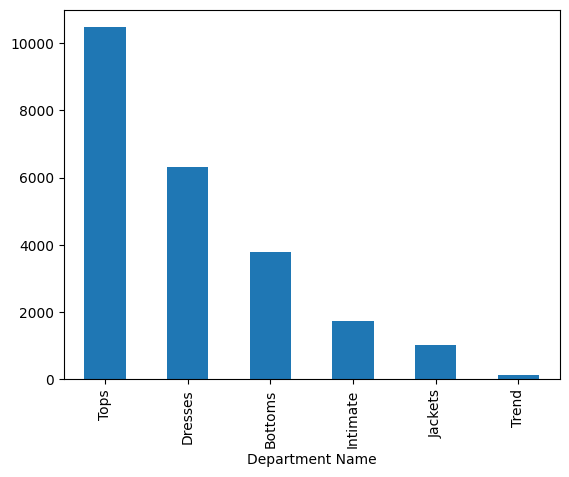

In [13]:
# Department distribution
df['Department Name'].value_counts().plot(kind='bar')

<Axes: >

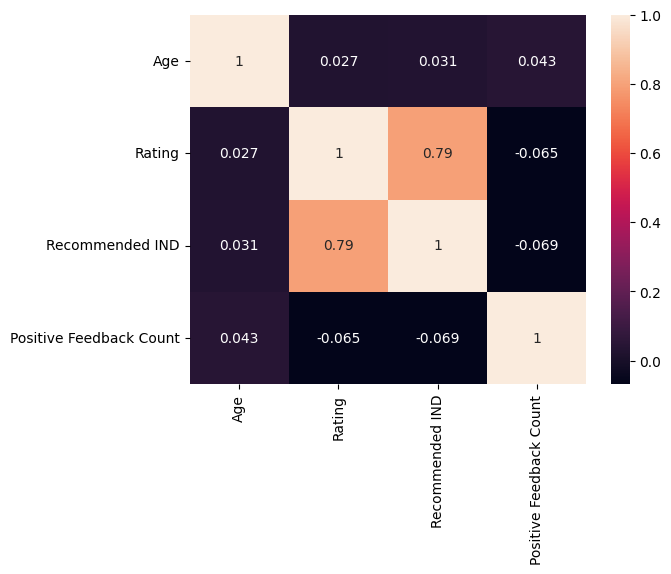

In [15]:
# Corelation between features in a heatmap
numerical_df = df.select_dtypes(include=['number'])
sns.heatmap(numerical_df.corr(), annot=True)

In [17]:
# checking special characters in reviews text
import re
special_chars = []
for i in range(5):
    text = df.iloc[i]["Review Text"]
    if isinstance(text, str):
        chars = re.findall(r'[^\w\s]', text)
        special_chars.extend(chars)
print("\nSample special characters found in reviews:")
print(set(special_chars))


Sample special characters found in reviews:
{'.', '"', ')', '-', "'", ',', '!', '('}


In [20]:
sample_with_title = df[df['Title'].notnull()].iloc[0]
sample_with_title["Title"]

'Some major design flaws'

In [22]:
sample_without_title = df[df['Title'].isnull()].iloc[0]
sample_without_title["Review Text"]

'Absolutely wonderful - silky and sexy and comfortable'

In [23]:
df["Age"].describe()

,Age
count,23486.000000
mean,43.198544
std,12.279544
min,18.000000
25%,34.000000
50%,41.000000
75%,52.000000
max,99.000000


In [24]:
df['Positive Feedback Count'].describe()

,Positive Feedback Count
count,23486.000000
mean,2.535936
std,5.702202
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,122.000000


# *Data Preperation*

In [26]:
# Checking outliers in the numerical columns
for column in numerical_df.columns:
    q1 = numerical_df[column].quantile(0.25)
    q3 = numerical_df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = numerical_df[(numerical_df[column] < lower_bound) | (numerical_df[column] > upper_bound)]
    print(f"Outliers in {column}:")
    print(outliers)

Outliers in Age:
       Age  Rating  Recommended IND  Positive Feedback Count
95      83       5                1                       14
234     83       5                1                        0
277     83       5                1                        1
628     80       5                1                        6
659     93       5                1                        3
...    ...     ...              ...                      ...
22640   80       5                1                        8
22716   87       4                1                        0
22773   83       5                1                        0
23001   83       5                1                        3
23033   86       5                1                        8

[109 rows x 4 columns]
Outliers in Rating:
       Age  Rating  Recommended IND  Positive Feedback Count
5       49       2                0                        4
22      31       2                0                        7
26      33       2      

In [46]:
# function to clean the text
def clean_text(text):
  """Clean and preprocess text data
  Parameters:
  -----------
  text : str
  The text to clean

  Returns:
  --------
  str
  Cleaned text
  """

  # Convert to lowercase
  text = text.lower()

  # Handle contractions
  contractions = {
      "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not","haven't": "have not",
      "hasn't": "has not", "hadn't": "had not", "doesn't": "does not", "don't": "do not", "didn't": "did not",
      "won't": "will not", "wouldn't": "would not", "can't": "cannot", "couldn't": "could not", "shouldn't": "should not",
      "mightn't": "might not", "mustn't": "must not", "i'm": "i am", "you're": "you are", "he's": "he is", "she's": "she is",
      "it's": "it is", "we're": "we are", "they're": "they are", "i've": "i have", "you've": "you have", "we've": "we have",
      "they've": "they have", "i'd": "i would", "you'd": "you would", "he'd": "he would", "she'd": "she would", "it'd": "it would",
      "we'd": "we would", "they'd": "they would", "i'll": "i will", "you'll": "you will", "he'll": "he will", "she'll": "she will",
      "it'll": "it will", "we'll": "we will", "they'll": "they will", "didnt": "did not", "dont": "do not", "cant": "cannot", "wont": "will not",
      }

  for contraction, expansion in contractions.items():
    text = text.replace(contraction, expansion)

  # Preserve important product-specific terms
  product_terms = ['xs', 'xxs', 'xl', 'xxl', '5\'8"', '5\'4"']
  term_placeholders = {term: f"TERM_{i}" for i, term in enumerate(product_terms)}

  for term, placeholder in term_placeholders.items():
    text = text.replace(term, placeholder)

  # Remove URLs
  text = re.sub(r'http\S+', '', text)

  # Remove email addresses
  text = re.sub(r'\S+@\S+', '', text)

  # Preserve emotions
  emoticons = {
      ':)': ' HAPPY_FACE ',
      ':(': ' SAD_FACE ',
      ':D': ' LAUGH_FACE ',
      ':/': ' CONFUSED_FACE '
      }
  for emoticon, replacement in emoticons.items():
    text = text.replace(emoticon, replacement)


  # Remove punctuation but preserve sentence structure
  text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)

  # Remove extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()

  # Restore product-specific terms
  for term, placeholder in term_placeholders.items():
    text = text.replace(placeholder, term)

  # Restore emotions
  for placeholder, emoticon in {v: k for k, v in emoticons.items()}.items():
    text = text.replace(placeholder, emoticon)

  return text

In [47]:
processed_df = df.copy()
processed_df['Cleaned Review'] = processed_df['Review Text'].astype(str).apply(clean_text)
# Handling missing review text
missing_review = processed_df['Review Text'].isnull()
processed_df.loc["missing_review", "Cleaned Review"] = ""
processed_df['has_review_text'] = ~missing_review # Adding a cloumn indicating if there is a null value or not in review text column

In [48]:
processed_df["Cleaned_title"] = processed_df["Title"].astype(str).apply(clean_text)
# Handling missing Title
missing_title = processed_df['Title'].isnull()
processed_df.loc["missing_title", "Cleaned_title"] = ""
processed_df['has_title'] = ~missing_title # Adding column indicating if there is a null value on title column or not

In [50]:
processed_df["Cleaned Review"][20]

'if this product was in petite i would get the petite the regular is a little long on me but a tailor can do a simple fix on that fits nicely i am 5 4 130lb and pregnant so i bough t medium to grow into the tie can be front or back so provides for some nice flexibility on form fitting'

In [53]:
!pip install nltk

In [54]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [57]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [60]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [58]:
# Function to tokenize the text
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def tokenize_and_lemmatize_text(text):
  """
  Parameters:
  -----------
  text : str
  The text to process

  Returns:
  --------
  List
  List of processed tokens
  """
  # If there is no text return empty list
  if not text:
    return []

  tokens = word_tokenize(text)
  # Removing stopwords such as "of", "and", "or", etc and lemmatize
  stop_words = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in stop_words]
  return tokens

In [62]:
processed_df["Tokenized Review"] = processed_df["Cleaned Review"].astype(str).apply(tokenize_and_lemmatize_text)
processed_df["Tokenized Title"] = processed_df["Cleaned_title"].astype(str).apply(tokenize_and_lemmatize_text)

In [63]:
# Combining review and title in a text processed field
processed_df['processed_text'] = processed_df.apply(lambda row: ' '.join(row['Tokenized Title'] + row['Tokenized Review']), axis=1)

In [64]:
processed_df["processed_text"][20]

'cute crisp shirt product petite would get petite regular little long tailor simple fix fit nicely 5 4 130lb pregnant bough medium grow tie front back provides nice flexibility form fitting'

In [68]:
# checking for truncated reviews
processed_df['is_truncated'] = processed_df['Cleaned Review'].astype(str).apply( lambda x: x.endswith('...') or len(x) >= 500)
truncated_count = processed_df['is_truncated'].sum()
print(f"Number of truncated reviews: {truncated_count}")

Number of truncated reviews: 173


In [70]:
# text length features
processed_df['review_char_count'] = processed_df['Cleaned Review'].astype(str).apply(len)
processed_df['review_word_count'] = processed_df['Tokenized Review'].astype(str).apply(len)
processed_df['title_word_count'] = processed_df['Tokenized Title'].astype(str).apply(len)

In [71]:
processed_df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Cleaned Review,has_review_text,Cleaned_title,has_title,Tokenized Review,Tokenized Title,processed_text,is_truncated,review_char_count,review_word_count,title_word_count
0,33.0,NaN,absolutely wonderful - silky and sexy and comf...,4.0,1.0,0.0,Initmates,Intimate,Intimates,absolutely wonderful silky and sexy and comfor...,True,nan,False,"[absolutely, wonderful, silky, sexy, comfortable]",[nan],nan absolutely wonderful silky sexy comfortable,False,51,59,7
1,34.0,NaN,love this dress! it's sooo pretty. i happene...,5.0,1.0,4.0,General,Dresses,Dresses,love this dress it is sooo pretty i happened t...,True,nan,False,"[love, dress, sooo, pretty, happened, find, st...",[nan],nan love dress sooo pretty happened find store...,False,295,278,7
2,60.0,some major design flaws,i had such high hopes for this dress and reall...,3.0,0.0,0.0,General,Dresses,Dresses,i had such high hopes for this dress and reall...,True,some major design flaws,True,"[high, hope, dress, really, wanted, work, init...","[major, design, flaw]",major design flaw high hope dress really wante...,False,485,446,27
3,50.0,my favorite buy!,"i love, love, love this jumpsuit. it's fun, fl...",5.0,1.0,0.0,General Petite,Bottoms,Pants,i love love love this jumpsuit it is fun flirt...,True,my favorite buy,True,"[love, love, love, jumpsuit, fun, flirty, fabu...","[favorite, buy]",favorite buy love love love jumpsuit fun flirt...,False,117,131,19
4,47.0,flattering shirt,this shirt is very flattering to all due to th...,5.0,1.0,6.0,General,Tops,Blouses,this shirt is very flattering to all due to th...,True,flattering shirt,True,"[shirt, flattering, due, adjustable, front, ti...","[flattering, shirt]",flattering shirt shirt flattering due adjustab...,False,187,159,23


In [74]:
processed_df["Department Name"].isnull().sum()

np.int64(16)

In [78]:
# Function for categorical encoding of the categorical data
def preprocess_categorical_columns(processed_df):
  if processed_df is None:
    print("No dataframe to preprocess")
    return

  # Handling missing values in Categorical columns
  categorical_columns = ['Department Name', 'Class Name', "Division Name"]
  for col in categorical_columns:
    missing_count = processed_df[col].isnull().sum()
    if missing_count > 0:
      processed_df[col].fillna("Unknown", inplace=True)

  # create one-hot encoding
  for col in categorical_columns:
    dummies = pd.get_dummies(processed_df[col], prefix=col.replace(' ', '_'))
    processed_df = pd.concat([processed_df, dummies], axis=1)

  return processed_df

In [80]:
processed_df = preprocess_categorical_columns(processed_df)

<ipython-input-78-dcafa7848664>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_df[col].fillna("Unknown", inplace=True)


In [81]:
processed_df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Cleaned Review,...,Class_Name_Skirts,Class_Name_Sleep,Class_Name_Sweaters,Class_Name_Swim,Class_Name_Trend,Class_Name_Unknown,Division_Name_General,Division_Name_General Petite,Division_Name_Initmates,Division_Name_Unknown
0,33.0,NaN,absolutely wonderful - silky and sexy and comf...,4.0,1.0,0.0,Initmates,Intimate,Intimates,absolutely wonderful silky and sexy and comfor...,...,False,False,False,False,False,False,False,False,True,False
1,34.0,NaN,love this dress! it's sooo pretty. i happene...,5.0,1.0,4.0,General,Dresses,Dresses,love this dress it is sooo pretty i happened t...,...,False,False,False,False,False,False,True,False,False,False
2,60.0,some major design flaws,i had such high hopes for this dress and reall...,3.0,0.0,0.0,General,Dresses,Dresses,i had such high hopes for this dress and reall...,...,False,False,False,False,False,False,True,False,False,False
3,50.0,my favorite buy!,"i love, love, love this jumpsuit. it's fun, fl...",5.0,1.0,0.0,General Petite,Bottoms,Pants,i love love love this jumpsuit it is fun flirt...,...,False,False,False,False,False,False,False,True,False,False
4,47.0,flattering shirt,this shirt is very flattering to all due to th...,5.0,1.0,6.0,General,Tops,Blouses,this shirt is very flattering to all due to th...,...,False,False,False,False,False,False,True,False,False,False


In [82]:
# Function to handle numerical data

def preprocess_numerical_columns(processed_df):
  if processed_df is None:
    print("No dataframe to preprocess")
    return

  # Handling Age outliers
  q1 = processed_df['Age'].quantile(0.25)
  q3 = processed_df['Age'].quantile(0.75)
  iqr = q3 - q1
  lower_bound = max(18, q1 - 1.5 * iqr)  # Minimum age is 18
  upper_bound = min(100, q3 + 1.5 * iqr) # Maximum age is 100
  age_outliers = processed_df[(processed_df['Age'] < lower_bound) | (processed_df['Age'] > upper_bound)]
  # Capping the outliers
  processed_df['Age_Processed'] = processed_df['Age'].clip(lower_bound, upper_bound)
  # Normalize age to 0-1 range
  processed_df['Age_Normalized'] = (processed_df['Age_Processed'] - lower_bound) / (upper_bound - lower_bound)

  # Applying log transformation on Positive feedback count column
  processed_df['Positive_Feedback_Log'] = np.log1p(processed_df['Positive Feedback Count'])
  # Normalize to range 0-1
  max_log_feedback = processed_df['Positive_Feedback_Log'].max()
  processed_df['Positive_Feedback_Normalized'] = processed_df['Positive_Feedback_Log'] / max_log_feedback

  return processed_df

In [83]:
processed_df = preprocess_numerical_columns(processed_df)

In [85]:
# function to make sentment labeling

def create_sentement_label(processed_df):
  if processed_df is None:
    print("No dataframe to preprocess")
    return

  conditions = [(processed_df['Rating'] >= 4) & (processed_df['Recommended IND'] == 1),
   (processed_df['Rating'] <= 2) & (processed_df['Recommended IND'] == 0),
   (processed_df['Rating'] == 3) | ((processed_df['Rating'] >= 4) & (processed_df['Recommended IND'] == 0)) |
   ((processed_df['Rating'] <= 2) & (processed_df['Recommended IND'] == 1))
   ]

  choices = ['Positive', 'Negative', 'Neutral']
  processed_df['sentiment_label'] = np.select(conditions, choices, default='Unknown')
  processed_df['sentiment_score'] = (processed_df['Rating'] - 1) / 4  # Scale to 0-1

  # Higher confidence for extreme ratings and matching recommendation
  processed_df['sentiment_confidence'] = np.where((processed_df['Rating'] == 5) & (processed_df['Recommended IND'] == 1), 1.0,
                                        np.where((processed_df['Rating'] == 1) & (processed_df['Recommended IND'] == 0), 1.0,
                                      np.where((processed_df['Rating'] == 3), 0.5, 0.75)))

  """
      If the review has:
      a Rating of 5 (very positive) and the person recommended the product,
      -> assign 1.0 confidence (high confidence that it's positive sentiment)

      Else if the review has:
      a Rating of 1 (very negative) and the person did not recommend the product,
      -> assign 1.0 confidence (high confidence it’s negative)

      Else if the review has:
      a Rating of 3,
      -> assign 0.5 confidence (neutral/mixed)

      Else, for all other combinations,
      -> assign 0.75 confidence (somewhat confident)
  """

  return processed_df

In [86]:
processed_df = create_sentement_label(processed_df)

In [87]:
processed_df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Cleaned Review,...,Division_Name_General Petite,Division_Name_Initmates,Division_Name_Unknown,Age_Processed,Age_Normalized,Positive_Feedback_Log,Positive_Feedback_Normalized,sentiment_label,sentiment_score,sentiment_confidence
0,33.0,NaN,absolutely wonderful - silky and sexy and comf...,4.0,1.0,0.0,Initmates,Intimate,Intimates,absolutely wonderful silky and sexy and comfor...,...,False,True,False,33.0,0.245902,0.000000,0.000000,Positive,0.75,0.75
1,34.0,NaN,love this dress! it's sooo pretty. i happene...,5.0,1.0,4.0,General,Dresses,Dresses,love this dress it is sooo pretty i happened t...,...,False,False,False,34.0,0.262295,1.609438,0.334451,Positive,1.00,1.00
2,60.0,some major design flaws,i had such high hopes for this dress and reall...,3.0,0.0,0.0,General,Dresses,Dresses,i had such high hopes for this dress and reall...,...,False,False,False,60.0,0.688525,0.000000,0.000000,Neutral,0.50,0.50
3,50.0,my favorite buy!,"i love, love, love this jumpsuit. it's fun, fl...",5.0,1.0,0.0,General Petite,Bottoms,Pants,i love love love this jumpsuit it is fun flirt...,...,True,False,False,50.0,0.524590,0.000000,0.000000,Positive,1.00,1.00
4,47.0,flattering shirt,this shirt is very flattering to all due to th...,5.0,1.0,6.0,General,Tops,Blouses,this shirt is very flattering to all due to th...,...,False,False,False,47.0,0.475410,1.945910,0.404371,Positive,1.00,1.00


In [89]:
processed_df['sentiment_label'].value_counts()

,count
sentiment_label,
Positive,18015
Neutral,3174
Negative,2297
Unknown,2
